# Improving Algorithm Based Trading
## Batch -1 / Group - 2

### Review 1 (10/10/2020)

#### Members
- CB.EN.U4CSE17003 - Abhishek S
- CB.EN.U4CSE17027 - R Jaswanth
- CB.EN.U4CSE17054 - Sanjay Bharadwaj V
- CB.EN.U4CSE17068 - Sri Ram V

In [1]:
import numpy as np
import pandas as pd 

# Visualisation
import matplotlib.pyplot as plt

from datetime import datetime

# Scaling
from sklearn.preprocessing import MinMaxScaler

# Deep Learning using Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Model insights
import tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

## Loading data from CSV file to DataFrame

In [2]:
df=pd.read_csv('archive-nifty/SBIN.csv',date_parser=True)

In [3]:
df.shape

(5163, 15)

In [4]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,SBIN,EQ,225.60,236.00,243.65,234.25,243.65,243.65,240.83,2373228,5.715338e+13,NaN,NaN,NaN
1,2000-01-04,SBIN,EQ,243.65,243.65,262.00,238.85,258.00,259.10,251.46,4495741,1.130506e+14,NaN,NaN,NaN
2,2000-01-05,SBIN,EQ,259.10,249.00,264.70,245.00,249.05,248.45,252.35,3434058,8.666008e+13,NaN,NaN,NaN
3,2000-01-06,SBIN,EQ,248.45,252.00,268.00,252.00,260.50,261.00,262.18,6658801,1.745817e+14,NaN,NaN,NaN
4,2000-01-07,SBIN,EQ,261.00,261.50,279.90,255.00,279.00,273.30,269.02,7873985,2.118287e+14,NaN,NaN,NaN


In [5]:
df.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
5158,2020-09-24,SBIN,EQ,183.80,181.10,181.80,175.50,176.45,176.35,178.59,46115352,8.235929e+14,286558.0,12700503.0,0.2754
5159,2020-09-25,SBIN,EQ,176.35,179.00,182.75,176.15,182.25,182.20,179.71,46550618,8.365427e+14,213017.0,7170816.0,0.1540
5160,2020-09-28,SBIN,EQ,182.20,184.00,188.15,183.35,187.45,187.25,186.34,41921659,7.811519e+14,195148.0,6606392.0,0.1576
5161,2020-09-29,SBIN,EQ,187.25,188.50,188.95,183.25,185.30,185.05,185.23,35688939,6.610754e+14,146100.0,3785103.0,0.1061
5162,2020-09-30,SBIN,EQ,185.05,185.05,186.80,182.40,185.20,185.40,184.91,37642302,6.960341e+14,159069.0,5421166.0,0.1440


## Splitting data into Train and Test
As this is a sequential dataset we are splitting by date and not randomly

In [6]:
train=df[df['Date']<'2017-01-01']
test=df[df['Date']>='2017-01-01']

## Storing only required columns

In [7]:
cols=['Open','High','Low','Close','Volume']
train=train[cols]
test=test[cols]

## Scaling the data using Min-Max Scaler

In [8]:
scaler=MinMaxScaler()

nTrain=scaler.fit_transform(train)
nTrain

array([[0.02770549, 0.02842251, 0.02844804, 0.03052113, 0.02735847],
       [0.02998082, 0.03387238, 0.02983722, 0.03513514, 0.05186423],
       [0.03157206, 0.03467427, 0.0316945 , 0.03195461, 0.03960642],
       ...,
       [0.03164642, 0.03105092, 0.03234379, 0.03174556, 0.13558561],
       [0.03117053, 0.02996688, 0.0318455 , 0.03171569, 0.12301851],
       [0.03120027, 0.03099152, 0.03237399, 0.03247723, 0.12163166]])

## Storing data in a Numpy array

In [9]:
xTrain=[]
yTrain=[]
window=60

for i in range(window,nTrain.shape[0]):
    xTrain.append(nTrain[i-window:i])
    yTrain.append(nTrain[i,0])

xTrain,yTrain=np.array(xTrain),np.array(yTrain)

xTrain.shape,yTrain.shape

((4175, 60, 5), (4175,))

## Model Definition

In [10]:
model=Sequential()

model.add(LSTM(units=50, activation='tanh', return_sequences=True,recurrent_activation = "sigmoid", input_shape=(window,5)))
model.add(Dropout(0.2))

model.add(LSTM(units=60, activation='tanh', return_sequences=True, recurrent_activation = "sigmoid"))
model.add(Dropout(0.3))

model.add(LSTM(units=80, activation='tanh', return_sequences=True, recurrent_activation = "sigmoid"))
model.add(Dropout(0.4))

model.add(LSTM(units=120, activation='tanh', recurrent_activation = "sigmoid"))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            11200     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 60)            26640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [12]:
# Checkpoint to store weights for least obtained loss 
checkpoint = ModelCheckpoint('best.h5', monitor='loss', verbose=1,save_best_only=True, save_freq="epoch")

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

# Optimizer: Adam lr=0.001
# Loss Function: Mean Squared Error
model.compile(optimizer=Adam(), loss='mean_squared_error')

## Model Training

In [13]:
History = model.fit(xTrain,yTrain,epochs=100,callbacks=[checkpoint,tensorboard_callback])

Epoch 1/100
130/131 [============================>.] - ETA: 0s - loss: 0.0109
Epoch 00001: loss improved from inf to 0.01082, saving model to best.h5
131/131 [==============================] - 8s 59ms/step - loss: 0.0108
Epoch 2/100
131/131 [==============================] - ETA: 0s - loss: 0.0049
Epoch 00002: loss improved from 0.01082 to 0.00492, saving model to best.h5
131/131 [==============================] - 8s 57ms/step - loss: 0.0049
Epoch 3/100
130/131 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 00003: loss improved from 0.00492 to 0.00415, saving model to best.h5
131/131 [==============================] - 7s 57ms/step - loss: 0.0041
Epoch 4/100
130/131 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 00004: loss improved from 0.00415 to 0.00365, saving model to best.h5
131/131 [==============================] - 8s 61ms/step - loss: 0.0037
Epoch 5/100
130/131 [============================>.] - ETA: 0s - loss: 0.0034
Epoch 00005: loss improved

Epoch 80/100
130/131 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00080: loss did not improve from 0.00110
131/131 [==============================] - 7s 57ms/step - loss: 0.0012
Epoch 81/100
130/131 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00081: loss improved from 0.00110 to 0.00107, saving model to best.h5
131/131 [==============================] - 8s 57ms/step - loss: 0.0011
Epoch 82/100
130/131 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00082: loss did not improve from 0.00107
131/131 [==============================] - 7s 57ms/step - loss: 0.0011
Epoch 83/100
130/131 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 00083: loss did not improve from 0.00107
131/131 [==============================] - 7s 56ms/step - loss: 0.0012
Epoch 84/100
130/131 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 00084: loss did not improve from 0.00107
131/131 [==============================] - 7s 57ms/step -

## Loss function vs Epochs

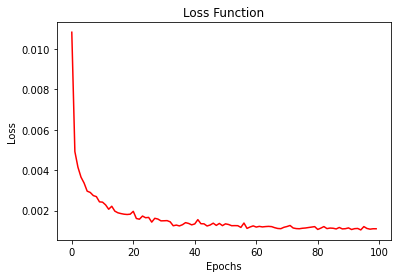

In [26]:
plt.plot(History.history['loss'],color="r",label="Training Accuracy")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss Function")
plt.show()

## Restoring the best weights

In [27]:
model = load_model('best.h5')

In [28]:
last_window=train.tail(window)
testSet=last_window.append(test,ignore_index=True)
nTest=scaler.transform(testSet)

In [29]:
xTest=[]
yTest=[]

for i in range(window,nTest.shape[0]):
    xTest.append(nTest[i-window:i])
    yTest.append(nTest[i,0])

xTest,yTest=np.array(xTest),np.array(yTest)
xTest.shape,yTest.shape

((928, 60, 5), (928,))

In [30]:
yPred=model.predict(xTest)

In [31]:
yPred

array([[0.04205027],
       [0.04110953],
       [0.04048812],
       [0.04020637],
       [0.0401715 ],
       [0.04048204],
       [0.04100257],
       [0.04128635],
       [0.04154646],
       [0.0419156 ],
       [0.04195723],
       [0.04194435],
       [0.04251271],
       [0.04317105],
       [0.04335073],
       [0.04274821],
       [0.04231566],
       [0.04226375],
       [0.04276565],
       [0.04407099],
       [0.04539344],
       [0.04546291],
       [0.044938  ],
       [0.04592934],
       [0.04739434],
       [0.04853633],
       [0.04905243],
       [0.04875621],
       [0.04831962],
       [0.04776125],
       [0.04809229],
       [0.04801501],
       [0.04772428],
       [0.04770386],
       [0.04794577],
       [0.04836106],
       [0.04856901],
       [0.04855205],
       [0.04837792],
       [0.04810262],
       [0.04787824],
       [0.04798697],
       [0.04763891],
       [0.04707804],
       [0.04695502],
       [0.04697478],
       [0.0471445 ],
       [0.047

In [32]:
scaler.scale_,scaler.data_min_

(array([2.97428729e-04, 2.96995887e-04, 3.01996195e-04, 2.98641183e-04,
        1.15456320e-08]),
 array([ 142.85,  147.95,  140.05,  141.45, 3633.  ]))

In [33]:
scaleVal=1/2.97428729e-04

## Inverse Scaling and Normalisation

In [34]:
yPred=(yPred*scaleVal)+testSet['Open'].min()
yTest=(yTest*scaleVal)+testSet['Open'].min()

In [35]:
yPred = (yPred*yTest.sum())/(yPred.sum())

## Plotting predicted values

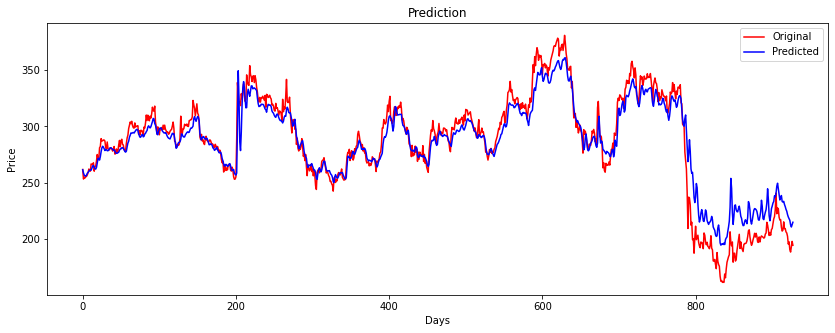

In [36]:
plt.figure(figsize=(14,5))
plt.plot(yTest,color='red',label='Original')
plt.plot(yPred,color='blue',label='Predicted')

plt.title('Prediction')
plt.xlabel('Days')
plt.ylabel('Price')

plt.legend()
plt.show()
